# Notebook 1: Hyperparameter Optimization

**Goal:** Find the best combination of learning rates (head and backbone) and weight decay for a specific experimental setup by running short training trials.

**Setup for this Run:**
*   **Model:** [Specify e.g., ResNet18]
*   **Unfreeze Strategy:** [Specify e.g., 'mid']
*   **Data Augmentation:** [Specify e.g., True/False]

This notebook will:
1. Define the experimental setup parameters.
2. Define a grid of hyperparameter combinations to test.
3. Run a short training loop (e.g., 5-10 epochs) for each combination on the validation set.
4. Record the validation performance for each combination.
5. Identify and save the best hyperparameter combination based on validation accuracy.
6. Save the full HPO history.

In [13]:
# --- Imports ---
import torch
import torch.nn as nn
import torch.optim as optim
import time
import os
from tqdm.notebook import tqdm # For progress bars
import utils

In [14]:
# --- Device Setup ---
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


We will examine 12 distinct "setups". Each setup will be a combination of the following:
1. `MODEL_NAME`: Either ResNet18 (`resnet`) or MobileNet_V3_Small (`mobilenet`).
2. `UNFREEZE_STRATEGY`: Either `head` (if training only the modified head), or `mid` (if training the head + a couple layers behind it), or `deep` (if training more layers behind it).
3. `AUGMENT_TRAIN`: Either `True` (if using data augmentation for training) or `False` (if not using data augmentation).

The particular setup will be denoted by a string `SETUP_ID` that combines these three parameters.
For example:
- if we are working with ResNet18, training a couple layers behind the head, and using data augmentation, then `SETUP_ID = resnet_mid_aug`.
- if we are working with MobileNet_V3_Small, training only the head, and not using data augmentation, then `SETUP_ID = mobilenet_head_noaug`.

In [ ]:
# --- Define Setup for this Notebook Run ---

# Unique identifier for this experimental setup (used for saving files)
SETUP_ID = 'resnet_mid_noaug' # <<< CHANGE THIS FOR EACH EXPERIMENT RUN >>>

MODEL_NAME = 'resnet'        # 'resnet18' or 'mobilenet'
UNFREEZE_STRATEGY = 'mid'    # 'head', 'mid', or 'deep'
AUGMENT_TRAIN = False         # True or False

# HPO Parameters
NUM_EPOCHS_HPO = 1            # Number of epochs to train *each* hyperparameter config
BATCH_SIZE = 64               # Batch size for HPO runs

In [16]:
# --- Unfreeze Strategy Mapping ---
# Define which layers/blocks correspond to each strategy
# (Ensure these names/substrings match model.named_parameters())
resnet_unfreeze_map = {
    'head': ['fc.'],
    'mid':  ['fc.', 'layer4.'],
    'deep': ['fc.', 'layer4.', 'layer3.']
}
mobilenet_unfreeze_map = {
    'head': ['classifier.3.'], # Example names, verify with model structure
    'mid':  ['classifier.3.', 'features.10.', 'features.11.', 'features.12.'],
    'deep': ['classifier.3.', 'features.8.', 'features.9.', 'features.10.', 'features.11.', 'features.12.']
}

# Select the appropriate unfreeze list based on setup
if MODEL_NAME == 'resnet':
    layers_to_unfreeze = resnet_unfreeze_map[UNFREEZE_STRATEGY]
elif MODEL_NAME == 'mobilenet':
    layers_to_unfreeze = mobilenet_unfreeze_map[UNFREEZE_STRATEGY]

In [17]:
print(f"Setup ID: {SETUP_ID}")
print(f"Model: {MODEL_NAME}, Unfreeze: {UNFREEZE_STRATEGY}, Augment: {AUGMENT_TRAIN}")
print(f"Layers to unfreeze contain: {layers_to_unfreeze}")
print(f"HPO Epochs per config: {NUM_EPOCHS_HPO}")

Setup ID: resnet_mid_aug
Model: resnet, Unfreeze: mid, Augment: False
Layers to unfreeze contain: ['fc.', 'layer4.']
HPO Epochs per config: 1


In [18]:
from sklearn.model_selection import ParameterGrid

hyperparams = {'lr_head': [5e-3, 1e-3],
               'lr_backbone': [1e-4, 5e-5],
               'weight_decay': [0.01, 0]}
hpo_configs = list(ParameterGrid(hyperparams))

print(f"Generated {len(hpo_configs)} hyperparameter configurations to test:")
hpo_configs

Generated 8 hyperparameter configurations to test:


[{'lr_backbone': 0.0001, 'lr_head': 0.005, 'weight_decay': 0.01},
 {'lr_backbone': 0.0001, 'lr_head': 0.005, 'weight_decay': 0},
 {'lr_backbone': 0.0001, 'lr_head': 0.001, 'weight_decay': 0.01},
 {'lr_backbone': 0.0001, 'lr_head': 0.001, 'weight_decay': 0},
 {'lr_backbone': 5e-05, 'lr_head': 0.005, 'weight_decay': 0.01},
 {'lr_backbone': 5e-05, 'lr_head': 0.005, 'weight_decay': 0},
 {'lr_backbone': 5e-05, 'lr_head': 0.001, 'weight_decay': 0.01},
 {'lr_backbone': 5e-05, 'lr_head': 0.001, 'weight_decay': 0}]

In [19]:
def run_hpo_trial(config: dict, hpo_epochs: int):
    """
    Trains a model configuration for a fixed number of epochs
    and returns the final validation accuracy.
    """
    print(f"--- Testing Config: {config} ---")
    start_time_trial = time.time()

    # 1. Load Model, adapt head, apply unfreeze-strategy, move to device
    model = utils.get_model(MODEL_NAME)
    model = utils.adapt_model_head(model, MODEL_NAME)
    model = utils.apply_unfreeze_logic(model, layers_to_unfreeze)
    model.to(device) 

    # 2. Load Datasets and DataLoaders
    train_dataset, val_dataset = utils.get_datasets(
        task = 'trainval',
        augment_train=AUGMENT_TRAIN
        )
    train_loader = utils.get_dataloaders(task='train', dataset=train_dataset, batch_size=BATCH_SIZE)
    val_loader = utils.get_dataloaders(task='val', dataset=val_dataset, batch_size=BATCH_SIZE)

    # 3. Setup Optimizer using current config
    optimizer = utils.get_optimizer(
        model=model,
        lr_head=config['lr_head'],
        lr_backbone=config['lr_backbone'],
        weight_decay=config['weight_decay']
    )

    # 4. Define Loss Function
    criterion = nn.CrossEntropyLoss()

    # 5. Training loop
    for epoch in range(hpo_epochs):
        # -- Training Step --
        model.train()
        running_loss = 0.0
        # Simple progress bar for training
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{hpo_epochs} Train", leave=False)
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            train_pbar.set_postfix(loss=loss.item())

        # -- Validation Step -- (record the last one for HPO)
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        # Simple progress bar for validation
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{hpo_epochs} Val", leave=False)
        with torch.no_grad():
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate validation accuracy for this epoch
        epoch_val_acc = 100 * correct / total
        epoch_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}/{hpo_epochs} - Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")

        # Store the results of the *last* epoch for this trial
        if epoch == hpo_epochs - 1:
             final_val_acc = epoch_val_acc
             final_val_loss = epoch_val_loss


    end_time_trial = time.time()
    print(f"--- Finished Config. Time: {end_time_trial - start_time_trial:.2f}s. Final Val Acc: {final_val_acc:.2f}% ---")

    # Return results for this configuration trial
    return {
        'config': config,
        'final_val_accuracy': final_val_acc,
        'final_val_loss': final_val_loss,
        'time_taken_secs': end_time_trial - start_time_trial
    }

In [20]:
print(f"Starting HPO loop for {len(hpo_configs)} configurations...")
hpo_results = []
total_hpo_start_time = time.time()

# Iterate through all defined hyperparameter configurations
for i, config in enumerate(hpo_configs):
    print(f"\n>>> Running HPO Trial {i+1}/{len(hpo_configs)}")
    trial_result = run_hpo_trial(config, hpo_epochs=1)
    hpo_results.append(trial_result)

total_hpo_end_time = time.time()
print(f"\n<<< HPO Loop Finished! Total Time: {(total_hpo_end_time - total_hpo_start_time)/60:.2f} minutes >>>")

Starting HPO loop for 8 configurations...

>>> Running HPO Trial 1/8
--- Testing Config: {'lr_backbone': 0.0001, 'lr_head': 0.005, 'weight_decay': 0.01} ---
Dataset split: Train samples = 2944, Val samples = 736


Epoch 1/1 Train:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1/1 Val:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/1 - Val Loss: 0.4552, Val Acc: 84.92%
--- Finished Config. Time: 56.95s. Final Val Acc: 84.92% ---

>>> Running HPO Trial 2/8
--- Testing Config: {'lr_backbone': 0.0001, 'lr_head': 0.005, 'weight_decay': 0} ---
Dataset split: Train samples = 2944, Val samples = 736


Epoch 1/1 Train:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1/1 Val:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/1 - Val Loss: 0.4032, Val Acc: 86.14%
--- Finished Config. Time: 48.60s. Final Val Acc: 86.14% ---

>>> Running HPO Trial 3/8
--- Testing Config: {'lr_backbone': 0.0001, 'lr_head': 0.001, 'weight_decay': 0.01} ---
Dataset split: Train samples = 2944, Val samples = 736


Epoch 1/1 Train:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1/1 Val:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/1 - Val Loss: 0.6351, Val Acc: 86.01%
--- Finished Config. Time: 49.27s. Final Val Acc: 86.01% ---

>>> Running HPO Trial 4/8
--- Testing Config: {'lr_backbone': 0.0001, 'lr_head': 0.001, 'weight_decay': 0} ---
Dataset split: Train samples = 2944, Val samples = 736


Epoch 1/1 Train:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1/1 Val:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/1 - Val Loss: 0.6297, Val Acc: 84.51%
--- Finished Config. Time: 48.85s. Final Val Acc: 84.51% ---

>>> Running HPO Trial 5/8
--- Testing Config: {'lr_backbone': 5e-05, 'lr_head': 0.005, 'weight_decay': 0.01} ---
Dataset split: Train samples = 2944, Val samples = 736


Epoch 1/1 Train:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1/1 Val:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/1 - Val Loss: 0.4996, Val Acc: 84.24%
--- Finished Config. Time: 48.84s. Final Val Acc: 84.24% ---

>>> Running HPO Trial 6/8
--- Testing Config: {'lr_backbone': 5e-05, 'lr_head': 0.005, 'weight_decay': 0} ---
Dataset split: Train samples = 2944, Val samples = 736


Epoch 1/1 Train:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1/1 Val:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/1 - Val Loss: 0.4942, Val Acc: 82.61%
--- Finished Config. Time: 48.73s. Final Val Acc: 82.61% ---

>>> Running HPO Trial 7/8
--- Testing Config: {'lr_backbone': 5e-05, 'lr_head': 0.001, 'weight_decay': 0.01} ---
Dataset split: Train samples = 2944, Val samples = 736


Epoch 1/1 Train:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1/1 Val:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/1 - Val Loss: 0.7832, Val Acc: 84.78%
--- Finished Config. Time: 48.54s. Final Val Acc: 84.78% ---

>>> Running HPO Trial 8/8
--- Testing Config: {'lr_backbone': 5e-05, 'lr_head': 0.001, 'weight_decay': 0} ---
Dataset split: Train samples = 2944, Val samples = 736


Epoch 1/1 Train:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1/1 Val:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/1 - Val Loss: 0.7859, Val Acc: 82.34%
--- Finished Config. Time: 49.31s. Final Val Acc: 82.34% ---

<<< HPO Loop Finished! Total Time: 6.65 minutes >>>


In [21]:
# Find the best configuration based on final validation accuracy
best_trial = None
best_val_accuracy = -1.0

for trial in hpo_results:
    if trial['final_val_accuracy'] > best_val_accuracy:
        best_val_accuracy = trial['final_val_accuracy']
        best_trial = trial

# Extract the best hyperparameter configuration
best_hyperparameters = best_trial['config'] if best_trial else None

print("\n--- HPO Results ---")
if best_hyperparameters:
    print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")
    print(f"Best Hyperparameters Found: {best_hyperparameters}")
else:
    print("No successful trials completed.")

# Define filenames for saving results
hpo_history_filename = f"hpo_history_{SETUP_ID}.json"
best_params_filename = f"best_params_{SETUP_ID}.json"

# Save the full HPO history (list of dictionaries)
utils.save_json(hpo_results, hpo_history_filename)
print(f"Full HPO history saved to: {hpo_history_filename}")

# Save only the best hyperparameter configuration
if best_hyperparameters:
    utils.save_json(best_hyperparameters, best_params_filename)
    print(f"Best hyperparameters saved to: {best_params_filename}")


--- HPO Results ---
Best Validation Accuracy: 86.14%
Best Hyperparameters Found: {'lr_backbone': 0.0001, 'lr_head': 0.005, 'weight_decay': 0}
Full HPO history saved to: hpo_history_resnet_mid_aug.json
Best hyperparameters saved to: best_params_resnet_mid_aug.json


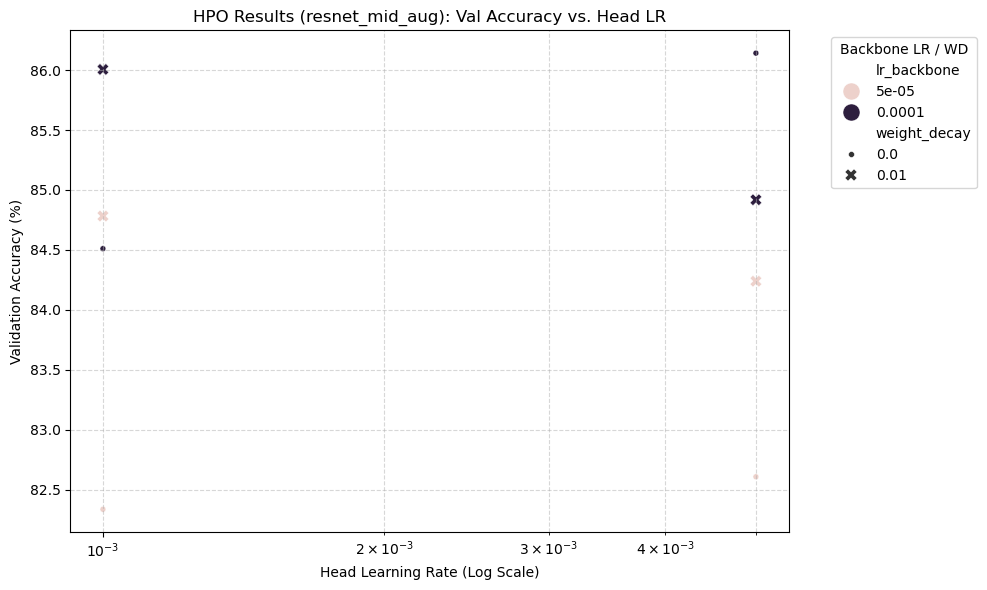

/var/folders/8h/w7q1fjwd5kn8xvqty5sp3h7r0000gn/T/ipykernel_43428/1625762140.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=hpo_df, x='weight_decay', y='val_accuracy', hue='lr_head', marker='o', ci=None) # Use lineplot if WD is treated categorically or has few values


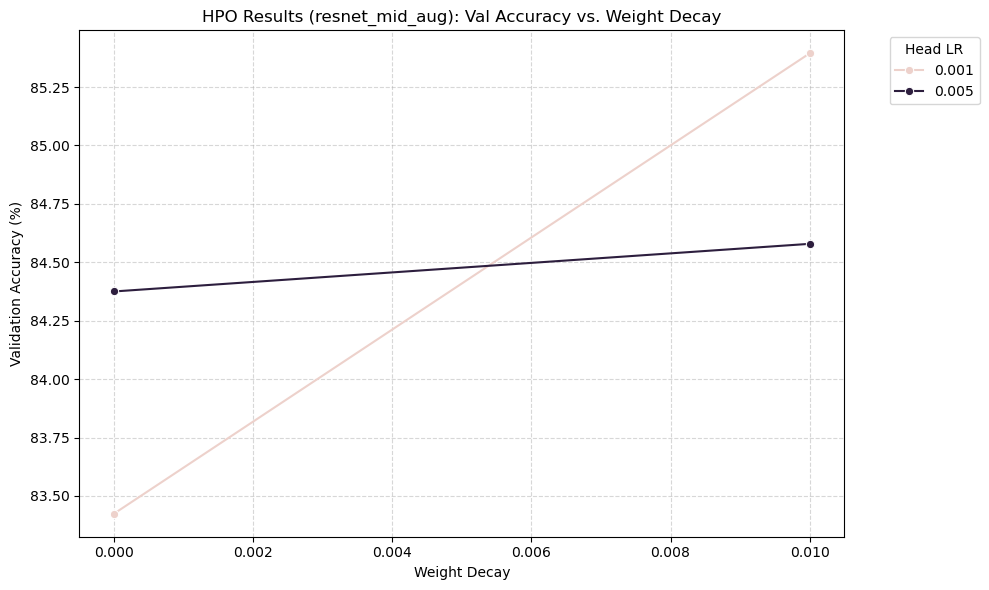

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert results to a Pandas DataFrame for easier plotting
hpo_df = pd.DataFrame([{**d['config'],
                        'val_accuracy': d['final_val_accuracy'],
                        'val_loss': d['final_val_loss']}
                       for d in hpo_results])

# Example Plot: Validation Accuracy vs Head Learning Rate, colored by Backbone LR
plt.figure(figsize=(10, 6))
sns.scatterplot(data=hpo_df, x='lr_head', y='val_accuracy', hue='lr_backbone', size='weight_decay', style='weight_decay', s=150)
plt.xscale('log') # Learning rates often plotted on log scale
plt.title(f'HPO Results ({SETUP_ID}): Val Accuracy vs. Head LR')
plt.xlabel('Head Learning Rate (Log Scale)')
plt.ylabel('Validation Accuracy (%)')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend(title='Backbone LR / WD', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Example Plot: Validation Accuracy vs Weight Decay, colored by Head LR
plt.figure(figsize=(10, 6))
sns.lineplot(data=hpo_df, x='weight_decay', y='val_accuracy', hue='lr_head', marker='o', ci=None) # Use lineplot if WD is treated categorically or has few values
# or use scatterplot if WD is continuous
# sns.scatterplot(data=hpo_df, x='weight_decay', y='val_accuracy', hue='lr_head', size='lr_backbone', style='lr_backbone', s=150)
plt.title(f'HPO Results ({SETUP_ID}): Val Accuracy vs. Weight Decay')
plt.xlabel('Weight Decay')
plt.ylabel('Validation Accuracy (%)')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend(title='Head LR', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()